<div class="span5 alert alert-info">
Attribute Information: This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:  
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.  
X2: Gender (1 = male; 2 = female).  
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).  
X4: Marital status (1 = married; 2 = single; 3 = others).  
X5: Age (year).  
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005.  The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.  
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.  
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.  
</div>

This module will import data, clean it, standardize, and perform a two classifiers: Logistic Regression and Gradient Boosting Classifier.

Evaluate the regression:  
Positive means predict likely to default.  Negative means unlikely to default.  
True positive is good.  
False Negative is very bad (means we predict NO default, but a default occurs.)  
Thus, FN and Recall are more important than overall score. 

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_validate, KFold
from sklearn.model_selection import train_test_split

cc_file = '/Users/brentmarijensen/Desktop/credit_card.xls'
df = pd.read_excel(cc_file,header=1)
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Clean up data, as described in CreditCardEDA.  Remove invalid numbers.
clean_df = df
clean_df = clean_df.drop('ID', axis=1)

# valid EDUCATION codes are 1,2,3,4.  Change other codes to 4, meaning "others."
for i in range (len(clean_df)):
    if clean_df['EDUCATION'][i] < 1:
        clean_df['EDUCATION'][i] = 4
    elif clean_df['EDUCATION'][i] > 4:
        clean_df['EDUCATION'][i] = 4
        
# valid MARRIAGE codes are 1,2,3.  Change other codes to 3, meaning "other."
for i in range (len(clean_df)):
    if clean_df['MARRIAGE'][i] < 1:
        clean_df['MARRIAGE'][i] = 3     
        
# PAY_1 to PAY_6.  Change column name PAY_0 to PAY_1
# change negative entries to 0, indicating 0 months behind.  
# a positive integer represents the number of months behind.
clean_df=clean_df.rename(columns = {'PAY_0':'PAY_1'})
vars = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for i in range (len(clean_df)):
    for var in vars:
        if clean_df[var][i]<0:
            clean_df[var][i] = 0  
            
# Standardize the data frame, and create X for predictor variables, y for target
X = clean_df.drop('default payment next month', axis=1).values
y = clean_df['default payment next month'].values
X_scaled = scale(X)
target = 'default payment next month'

/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [4]:
"""Perform Logistic regression with 10 fold cross validation.  Include recall and precision.
   This will give us a base before feature engineering."""
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

def regress(X,y) :
    clf = LogisticRegression(random_state=22)
    clf.fit(X,y)
    overall_score = cross_val_score(clf, X, y, cv=10)
    print('average cross-val score: ', overall_score.mean())
    scoring = ['average_precision','recall_macro']
    scores = cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False)
    print('recall: ',scores['test_recall_macro'].mean())
    print('precision: ',scores['test_average_precision'].mean())

print('regression score, unscaled variables: ')
regress(X,y)
print("")
print(" with scaled variables")
regress(X_scaled,y)

regression score, unscaled variables: 
average cross-val score:  0.7787667025592632
recall:  0.4999786050492084
precision:  0.3352175352533363

 with scaled variables
average cross-val score:  0.8181025170225018
recall:  0.6436989950840318
precision:  0.5286764909507363


In [7]:
# A sample binary classification dataset.  
# from: http://scikit-learn.org/stable/modules/model_evaluation.html
# cross val with scoring
scoring = ['accuracy', 'precision']
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=22)
scoring = {'accuracy': make_scorer(accuracy_score), 'prec': 'precision'}

def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
cv_results = cross_validate(logreg.fit(X, y), X, y, scoring=scoring)
# Getting the test set true positive scores
print(cv_results['test_tp'])          
# Getting the test set false negative scores
print(cv_results['test_fn'])  

#repeat with scaled variables:
cv_results = cross_validate(logreg.fit(X_scaled, y), X_scaled, y, scoring=scoring)
print('scaled: ')
print(cv_results['test_tp'])          
print(cv_results['test_fn'])  

[7787 7787 7787]
[1 1 1]
scaled: 
[7381 7424 7543]
[407 364 245]


In [13]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=22)
logreg.fit(X_scaled,y)

#cross validate for scoring
cv_results = cross_val_score(logreg, X_scaled, y, cv=10)
print('average cross-val score: ', cv_results.mean())

# Use train test split to find confusion matrix and classification report.
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y)
pred_logreg = logreg.predict(X_test)
print('recall score: ', metrics.recall_score(y_test,pred_logreg))
confusion = metrics.confusion_matrix(y_test, pred_logreg)
print("Confusion matrix: ")
print(" TN  FP")
print(" FN  TP")
print(confusion)
print(metrics.classification_report(y_test, pred_logreg))

/beer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


average cross-val score:  0.818102517023
recall score:  0.337237977805
Confusion matrix: 
 TN  FP
 FN  TP
[[5593  285]
 [1075  547]]
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      5878
          1       0.66      0.34      0.45      1622

avg / total       0.80      0.82      0.80      7500



In [15]:
#Gradient Boosting Classifier (tree based classifier)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, cross_validation

X = clean_df.drop('default payment next month', axis=1).values
y = clean_df['default payment next month'].values

clf = GradientBoostingClassifier(random_state=22)

predicted = cross_validation.cross_val_predict(clf, X, y, cv=10)
print('predicted accuracy score: ',metrics.accuracy_score(df['default payment next month'], predicted))
print(' ')
print(metrics.classification_report(y, predicted) )   

predicted accuracy score:  0.8209
 
             precision    recall  f1-score   support

          0       0.84      0.95      0.89     23364
          1       0.68      0.37      0.48      6636

avg / total       0.80      0.82      0.80     30000



normalized lasso score:  -3.22074178414e-05
lasso score:  0.0582474790928


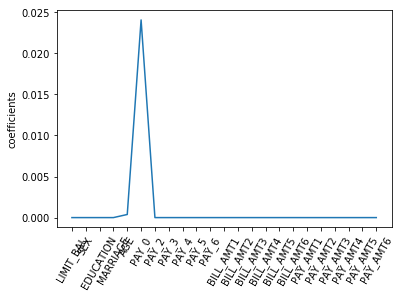

In [21]:
#one more thing: Lasso can show if any variables are more important than the others
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)

lasso = Lasso(alpha=0.1,normalize=True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print('normalized lasso score: ',lasso.score(X_test,y_test))

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print('lasso score: ',lasso.score(X_test,y_test))

names = clean_df.drop('default payment next month',axis=1).columns
lasso_coef = lasso.fit(X,y).coef_
_= plt.plot(range(len(names)), lasso_coef)
_= plt.xticks(range(len(names)), names, rotation=60)
_= plt.ylabel('coefficients')
plt.show()